In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/MSCS/260/ADE
%pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/MSCS/260/ADE'
/content/drive/MyDrive/MSCS/260/ADE
ADE_val_00001001.jpg  ADE_val_00001001_seg.png


In [ ]:
# ============================================================
# SegFormer Multi-Precision + P3109 Quantization + Analysis
# Multi ADE20K images + GT masks
# ============================================================

import os
import time
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Core: P3109 simulation (vectorized, safe)
# -----------------------------
def float_to_p3109(x: torch.Tensor, K: int = 8, P: int = 3, rounding: str = "nearest_even", preserve_dtype: bool = True, eps: float = 1e-45) -> torch.Tensor:
    if P < 1:
        raise ValueError("P must be >= 1")
    e_bits = K - P
    if e_bits < 1:
        raise ValueError("K and P invalid: need at least 1 exponent bit")
    f_bits = P - 1

    bias = (2 ** (e_bits - 1)) - 1
    max_stored_exp = (2 ** e_bits) - 2
    E_max_unbiased = max_stored_exp - bias
    E_min_unbiased = 1 - bias

    orig_shape = x.shape
    orig_dtype = x.dtype
    work_dtype = torch.float32 if orig_dtype != torch.float64 else torch.float64
    x_work = x.flatten().to(work_dtype)

    n = x_work.numel()
    out_flat = torch.zeros_like(x_work)

    is_nan = torch.isnan(x_work)
    is_inf = torch.isinf(x_work)
    signbit = torch.signbit(x_work)
    absx = x_work.abs()
    is_zero = (absx == 0)

    out_flat[is_nan] = float('nan')
    out_flat[is_inf] = torch.sign(x_work[is_inf]) * float('inf')

    finite_mask = torch.isfinite(x_work) & (~is_zero) & (~is_nan) & (~is_inf)
    if finite_mask.any():
        xf = absx[finite_mask]
        m, e = torch.frexp(xf)
        mant = m * 2.0
        exp_unbiased = e - 1

        normal_mask = (exp_unbiased >= E_min_unbiased) & (exp_unbiased <= E_max_unbiased)
        subnormal_mask = exp_unbiased < E_min_unbiased
        overflow_mask = exp_unbiased > E_max_unbiased

        idxs = torch.arange(xf.shape[0], device=xf.device)
        if normal_mask.any():
            nm_idx = idxs[normal_mask]
            mant_n = mant[normal_mask]
            exp_n = exp_unbiased[normal_mask].to(torch.long)

            f = mant_n - 1.0
            scaled = f * (2.0 ** f_bits)
            if rounding == "nearest_even":
                scaled_q = torch.round(scaled)
            elif rounding == "toward_zero":
                scaled_q = torch.trunc(scaled)
            elif rounding == "floor":
                scaled_q = torch.floor(scaled)
            elif rounding == "ceil":
                scaled_q = torch.ceil(scaled)
            else:
                raise ValueError("Unsupported rounding")

            carry_mask = (scaled_q >= (2 ** f_bits))
            if carry_mask.any():
                scaled_q = scaled_q.clone()
                exp_n = exp_n.clone()
                scaled_q[carry_mask] = 0.0
                exp_n[carry_mask] = exp_n[carry_mask] + 1

            overflow_after = exp_n > E_max_unbiased
            mant_q = 1.0 + scaled_q / (2.0 ** f_bits)
            val_n = mant_q * (2.0 ** exp_n)
            if overflow_after.any():
                val_n[overflow_after] = float('inf')

            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            normal_positions = finite_positions[nm_idx]
            out_flat[normal_positions] = val_n

        if subnormal_mask.any():
            sm_idx = idxs[subnormal_mask]
            scaled_fraction = xf[subnormal_mask] / (2.0 ** E_min_unbiased) * (2.0 ** f_bits)
            if rounding == "nearest_even":
                frac_q = torch.round(scaled_fraction)
            elif rounding == "toward_zero":
                frac_q = torch.trunc(scaled_fraction)
            elif rounding == "floor":
                frac_q = torch.floor(scaled_fraction)
            elif rounding == "ceil":
                frac_q = torch.ceil(scaled_fraction)
            else:
                raise ValueError("Unsupported rounding")

            frac_q = torch.clamp(frac_q, 0.0, float(2 ** f_bits - 1))
            val_s = (frac_q / (2.0 ** f_bits)) * (2.0 ** E_min_unbiased)

            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            sub_positions = finite_positions[sm_idx]
            out_flat[sub_positions] = val_s

        if overflow_mask.any():
            ov_idx = idxs[overflow_mask]
            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            ov_positions = finite_positions[ov_idx]
            out_flat[ov_positions] = float('inf')

    if signbit.any():
        out_flat[signbit] = -out_flat[signbit]

    if is_zero.any():
        zero_positions = torch.nonzero(is_zero, as_tuple=False).squeeze(1)
        out_flat[zero_positions] = x_work[zero_positions] * 0.0

    out = out_flat.view(orig_shape)
    return out.to(orig_dtype) if preserve_dtype else out

def float_to_p3109_safe(x, K=8, P=3, rounding="nearest_even", preserve_dtype=True):
    return float_to_p3109(x, K=K, P=P, rounding=rounding, preserve_dtype=preserve_dtype)

def quantize_model_p3109(model, K=8, P=3):
    for name, param in model.named_parameters():
        if param is None:
            continue
        with torch.no_grad():
            param.data.copy_(float_to_p3109_safe(param.data, K=K, P=P, preserve_dtype=True))
    return model

# -----------------------------
# Visualization utils
# -----------------------------
def visualize_comparison(original_image, pred_mask, title, save_path):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# -----------------------------
# Error metrics
# -----------------------------
def compute_error(a,b):
    a,b = a.float(), b.float()
    return {"MAE": float(torch.mean(torch.abs(a-b)).item()),
            "L2": float(torch.norm(a-b).item()),
            "MaxAbs": float(torch.max(torch.abs(a-b)).item())}

def dice_coeff(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    return (2.0 * intersection) / (pred_flat.numel() + target_flat.numel() + eps)

def iou_score(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    union = pred_flat.numel() + target_flat.numel() - intersection
    return intersection / (union + eps)

# -----------------------------
# ADE20K RGB mask -> class IDs
# -----------------------------
def ade20k_rgb_to_id(mask: Image.Image):
    # ADE20K palette 需要完整 150 类，这里简化示例，背景=0, 其他=1
    mask_np = np.array(mask)
    H, W, _ = mask_np.shape
    class_map = np.zeros((H,W), dtype=np.int64)
    # 这里可添加完整 palette 映射
    class_map[np.any(mask_np != 0, axis=2)] = 1
    return class_map
# -----------------------------
# Main experiment
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"

os.makedirs("pred_visualizations", exist_ok=True)
os.makedirs("features_cache", exist_ok=True)
os.makedirs("metrics_cache", exist_ok=True)

precisions = ["P3109","FP32","FP64","TF32","BFloat16"]

model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
processor = SegformerImageProcessor.from_pretrained(model_name)
model.eval()

# -----------------------------
# 多对 ADE20K 图片 + GT mask 列表
# -----------------------------
image_mask_pairs = [
    ("ADE_val_00001001.jpg", "ADE_val_00001001_seg.png"),
    # 可以继续添加其他图片
    # ("ADE_val_00001002.jpg", "ADE_val_00001002_seg.png"),
]

feature_records = []

for idx, (img_path, mask_path) in enumerate(image_mask_pairs):
    print(f"\n--- Processing Image {idx+1} ---")
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    gt_mask_tensor = torch.from_numpy(np.array(mask)).long()

    inputs = processor(images=image, return_tensors="pt").to(device)
    all_features = {}
    all_metrics = {}
    timings = {}

    for p in precisions:
        print(f"\n>>> Running precision: {p}")
        start = time.time()

        layer_outputs = {}

        if p == "P3109":
            p_model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
            p_model.eval()
            quantize_model_p3109(p_model, K=8, P=3)
            for name, module in p_model.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: float_to_p3109_safe(o)})
                    module.register_forward_hook(make_hook(name))
            p_inputs = {k: float_to_p3109_safe(v) if torch.is_tensor(v) else v for k, v in inputs.items()}
            with torch.no_grad():
                outputs = p_model(**p_inputs)

        elif p == "FP32":
            model_fp = model.float()
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.float() for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        elif p == "FP64":
            model_fp = model.double()
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.double() for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        elif p == "TF32":
            torch.backends.cuda.matmul.allow_tf32 = True
            model_fp = model.float()
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.float() for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        elif p == "BFloat16":
            model_fp = model.to(device).to(torch.bfloat16)
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: (v.to(torch.bfloat16) if torch.is_tensor(v) else v) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        pred_mask = outputs.logits.argmax(dim=1)[0].detach().cpu()  # (H_pred, W_pred)

        # Resize GT mask
        gt_mask_id = ade20k_rgb_to_id(mask)  # (H, W)
        gt_mask_tensor = torch.from_numpy(gt_mask_id).long()  # (H, W)
        gt_mask_tensor_float = gt_mask_tensor.unsqueeze(0).unsqueeze(0).float()  # (1,1,H,W)

        H_pred, W_pred = pred_mask.shape
        gt_mask_resized = F.interpolate(gt_mask_tensor_float, size=(H_pred, W_pred), mode='nearest').squeeze(0).squeeze(0).long()

        visualize_comparison(image, pred_mask.numpy(), f"{p} Prediction",
                             f"pred_visualizations/img{idx+1}_{p}_compare.png")

        # 计算指标
        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask_resized.flatten()
        min_len = min(len(pred_flat), len(gt_flat))
        acc = (pred_flat[:min_len] == gt_flat[:min_len]).float().mean().item()
        dice = dice_coeff(pred_mask, gt_mask_resized)
        iou = iou_score(pred_mask, gt_mask_resized)
        all_metrics[p] = {"pixel_acc": acc, "dice": dice, "iou": iou}

        timings[p] = time.time() - start
        print(f"Precision {p} finished in {timings[p]:.4f} seconds")

        all_features[p] = layer_outputs

        torch.save(layer_outputs, f'features_cache/img{idx+1}_{p}.pt')
        torch.save(all_metrics[p], f'metrics_cache/img{idx+1}_{p}.pt')

    # -----------------------------
    # 对比 FP32 baseline
    baseline_feats = all_features.get("FP32", {})
    for p in precisions:
        if p == "FP32":
            continue
        layer_outputs_p = all_features.get(p, {})
        print(f"\n>>> Precision {p}: analyzed {len(layer_outputs_p)} layers")

        # 保存每个精度分析的层名
        analyzed_layers = list(layer_outputs_p.keys())
        os.makedirs(f"features_cache/layers_analyzed", exist_ok=True)
        with open(f"features_cache/layers_analyzed/img{idx+1}_{p}.txt", "w") as f:
            for layer_name in analyzed_layers:
                f.write(layer_name + "\n")

        for layer_name, feat in all_features[p].items():
            if layer_name not in baseline_feats:
                continue
            a = baseline_feats[layer_name]
            b = feat
            if isinstance(a, (list, tuple)) or isinstance(b, (list, tuple)):
                try:
                    for i_el in range(min(len(a), len(b))):
                        e = compute_error(a[i_el].float(), b[i_el].float())
                        feature_records.append({
                            "image_idx": idx+1,
                            "precision": p,
                            "layer": layer_name,
                            "elem_idx": i_el,
                            **e
                        })
                except Exception:
                    continue
            else:
                try:
                    e = compute_error(a.float(), b.float())
                    feature_records.append({
                        "image_idx": idx+1,
                        "precision": p,
                        "layer": layer_name,
                        "elem_idx": 0,
                        **e
                    })
                except Exception:
                    continue

    metrics_df = pd.DataFrame.from_dict(all_metrics, orient="index")
    metrics_df.to_csv(f"mask_metrics_img{idx+1}.csv")

if len(feature_records) > 0:
    feat_df = pd.DataFrame(feature_records)
    feat_df.to_csv("feature_diff_summary.csv", index=False)

print(" All images processed...")



--- Processing Image 1 ---

>>> Running precision: P3109
Precision P3109 finished in 52.7108 seconds

>>> Running precision: FP32
Precision FP32 finished in 4.8221 seconds

>>> Running precision: FP64
Precision FP64 finished in 15.4246 seconds

>>> Running precision: TF32
Precision TF32 finished in 6.0936 seconds

>>> Running precision: BFloat16
Precision BFloat16 finished in 675.8645 seconds

>>> Precision P3109: analyzed 188 layers

>>> Precision FP64: analyzed 188 layers

>>> Precision TF32: analyzed 188 layers

>>> Precision BFloat16: analyzed 188 layers
 All images processed...


In [ ]:
df = pd.read_csv("mask_metrics_img1.csv")
print(df.columns)
print(df.head())


Index(['Unnamed: 0', 'pixel_acc', 'dice', 'iou'], dtype='object')
  Unnamed: 0  pixel_acc      dice       iou
0      P3109   0.566711  0.566711  0.395392
1       FP32   0.515625  0.515625  0.347368
2       FP64   0.515625  0.515625  0.347368
3       TF32   0.515625  0.515625  0.347368
4   BFloat16   0.519043  0.519043  0.350478


In [ ]:
print("\n==== Debug: all_metrics content ====")
print(all_metrics)
print("Columns:", list(metrics_df.columns))

print("\n==== Debug: first few feature records ====")
for r in feature_records[:3]:
    print(r)



==== Debug: all_metrics content ====
{'P3109': {'pixel_acc': 0.56671142578125, 'dice': 0.5667114257639553, 'iou': 0.39539241151490895}, 'FP32': {'pixel_acc': 0.515625, 'dice': 0.5156249999842644, 'iou': 0.3473684210383483}, 'FP64': {'pixel_acc': 0.515625, 'dice': 0.5156249999842644, 'iou': 0.3473684210383483}, 'TF32': {'pixel_acc': 0.515625, 'dice': 0.5156249999842644, 'iou': 0.3473684210383483}, 'BFloat16': {'pixel_acc': 0.51904296875, 'dice': 0.5190429687341601, 'iou': 0.35047807449923846}}
Columns: ['pixel_acc', 'dice', 'iou']

==== Debug: first few feature records ====
{'image_idx': 1, 'precision': 'P3109', 'layer': 'segformer.encoder.patch_embeddings.0.proj', 'elem_idx': 0, 'MAE': 0.05514007806777954, 'L2': 92.54232788085938, 'MaxAbs': 1.0327625274658203}
{'image_idx': 1, 'precision': 'P3109', 'layer': 'segformer.encoder.patch_embeddings.0.layer_norm', 'elem_idx': 0, 'MAE': 0.04265782609581947, 'L2': 61.41262435913086, 'MaxAbs': 0.6270195245742798}
{'image_idx': 1, 'precision': '


 Loaded feature_diff_summary.csv, columns: ['image_idx', 'precision', 'layer', 'elem_idx', 'MAE', 'L2', 'MaxAbs']

 Top 10 layers with highest MAE:
                                                    MAE
layer                                                  
decode_head.linear_fuse                        1.878907
segformer.encoder.block.0.0.attention.self.sr  1.405973
segformer.encoder.block.0.1.attention.self.sr  0.976917
segformer.encoder.block.0.2.attention.self.sr  0.884073
segformer.encoder.block.1.2.attention.self.sr  0.491171
segformer.encoder.block.1.3.attention.self.sr  0.443386
segformer.encoder.block.1.1.attention.self.sr  0.428992
decode_head.classifier                         0.386352
segformer.encoder.block.0.2.layer_norm_2       0.366096
segformer.encoder.block.1.0.attention.self.sr  0.361122


<Figure size 1000x400 with 0 Axes>

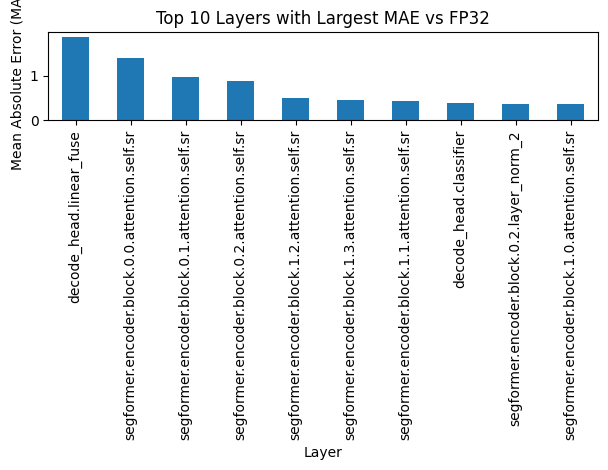


 Mean MAE per Precision:
                MAE
precision          
P3109      0.421432
BFloat16   0.032223
FP64       0.000003
TF32       0.000000


<Figure size 600x400 with 0 Axes>

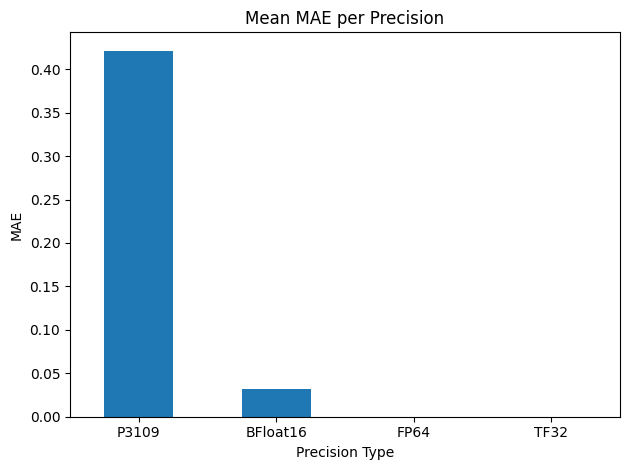


 Top 10 layers with largest L2 difference:
                                                   L2
layer                                                
decode_head.linear_fuse                   9265.155139
decode_head.classifier                     792.415083
segformer.encoder.block.0.2.mlp.dense1     645.827967
segformer.encoder.block.1.3.mlp.dense1     558.978620
segformer.encoder.block.0.2.layer_norm_2   526.105320
segformer.encoder.block.1.2.mlp.dense1     500.805942
segformer.encoder.block.0.1.mlp.dense1     459.532701
segformer.encoder.block.0.1.layer_norm_2   430.235684
segformer.encoder.block.2.3.mlp.dense1     381.729610
segformer.encoder.block.2.0.mlp.dense1     376.350941


<Figure size 1000x400 with 0 Axes>

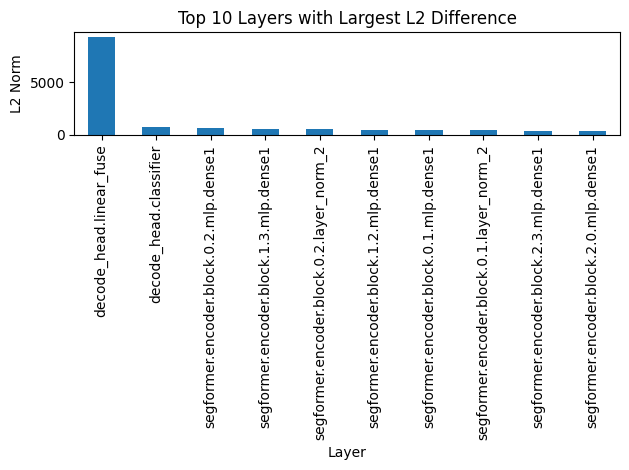


 Top 10 layers with largest MaxAbs difference:
                                                  MaxAbs
layer                                                   
decode_head.linear_fuse                        25.841421
segformer.encoder.block.1.3.mlp.dense2         14.075460
segformer.encoder.patch_embeddings.3.proj      11.761192
segformer.encoder.block.0.0.attention.self.sr  10.176858
segformer.encoder.patch_embeddings.2.proj       9.433342
segformer.encoder.block.0.1.attention.self.sr   8.680589
segformer.encoder.block.2.5.mlp.dense2          8.392701
segformer.encoder.block.0.2.attention.self.sr   8.339430
segformer.encoder.block.0.2.mlp.dense1          6.981939
segformer.encoder.block.0.2.layer_norm_2        6.879962


<Figure size 1000x400 with 0 Axes>

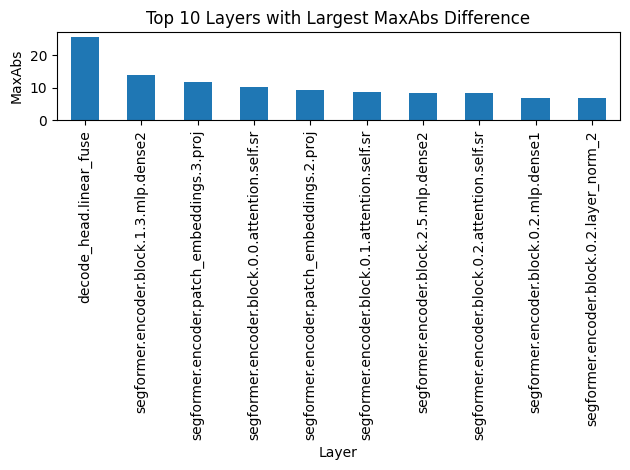

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ================================
# 读取 feature_diff_summary.csv
# ================================
df = pd.read_csv("feature_diff_summary.csv")

print("\n Loaded feature_diff_summary.csv, columns:", df.columns.tolist())

# ========================================================
# 1. 各 Layer MAE 平均值（Top-10）
# ========================================================
top10_layers = (
    df.groupby("layer")[["MAE"]]
    .mean()
    .sort_values("MAE", ascending=False)
    .head(10)
)

print("\n Top 10 layers with highest MAE:")
print(top10_layers)

# 画图
plt.figure(figsize=(10, 4))
top10_layers.plot(kind='bar', legend=False)
plt.title("Top 10 Layers with Largest MAE vs FP32")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Layer")
plt.xticks(rotation=90)
plt.tight_layout()

os.makedirs("plots", exist_ok=True)
plt.savefig("plots/top10_layers_mae.png")
plt.show()


# ========================================================
# 2. 各 Precision 的平均 MAE（例如 P3109、FP32、FP64...）
# ========================================================
precision_mae = (
    df.groupby("precision")[["MAE"]]
    .mean()
    .sort_values("MAE", ascending=False)
)

print("\n Mean MAE per Precision:")
print(precision_mae)

plt.figure(figsize=(6,4))
precision_mae.plot(kind='bar', legend=False)
plt.title("Mean MAE per Precision")
plt.ylabel("MAE")
plt.xlabel("Precision Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/precision_mae.png")
plt.show()


# ========================================================
# 3. 每个 Layer 的 L2 范数（Top-10）
# ========================================================
top10_l2 = (
    df.groupby("layer")[["L2"]]
    .mean()
    .sort_values("L2", ascending=False)
    .head(10)
)

print("\n Top 10 layers with largest L2 difference:")
print(top10_l2)

plt.figure(figsize=(10,4))
top10_l2.plot(kind='bar', legend=False)
plt.title("Top 10 Layers with Largest L2 Difference")
plt.ylabel("L2 Norm")
plt.xlabel("Layer")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plots/top10_layers_l2.png")
plt.show()


# ========================================================
# 4. 每个 Layer 的 MaxAbs（Top-10）
# ========================================================
top10_maxabs = (
    df.groupby("layer")[["MaxAbs"]]
    .mean()
    .sort_values("MaxAbs", ascending=False)
    .head(10)
)

print("\n Top 10 layers with largest MaxAbs difference:")
print(top10_maxabs)

plt.figure(figsize=(10,4))
top10_maxabs.plot(kind='bar', legend=False)
plt.title("Top 10 Layers with Largest MaxAbs Difference")
plt.ylabel("MaxAbs")
plt.xlabel("Layer")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plots/top10_layers_maxabs.png")
plt.show()


Displaying img1_BFloat16_compare.png


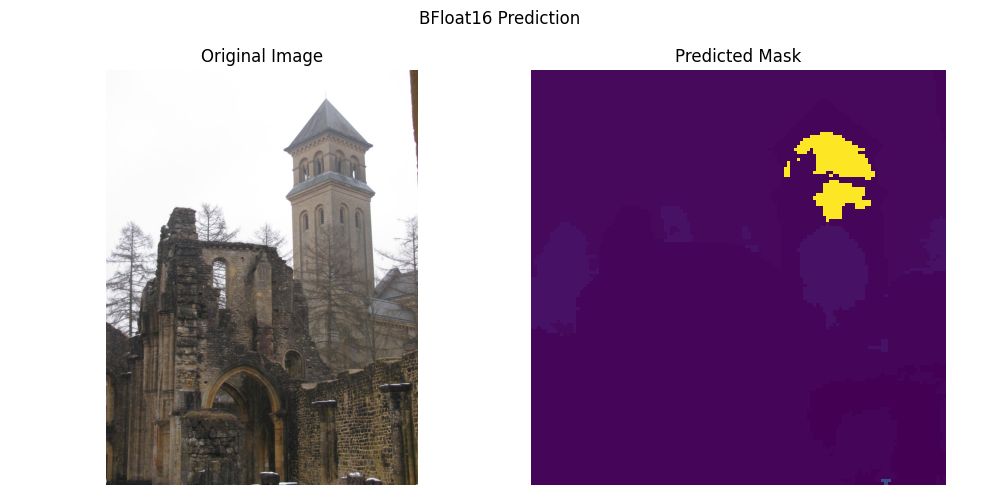

Displaying img1_FP32_compare.png


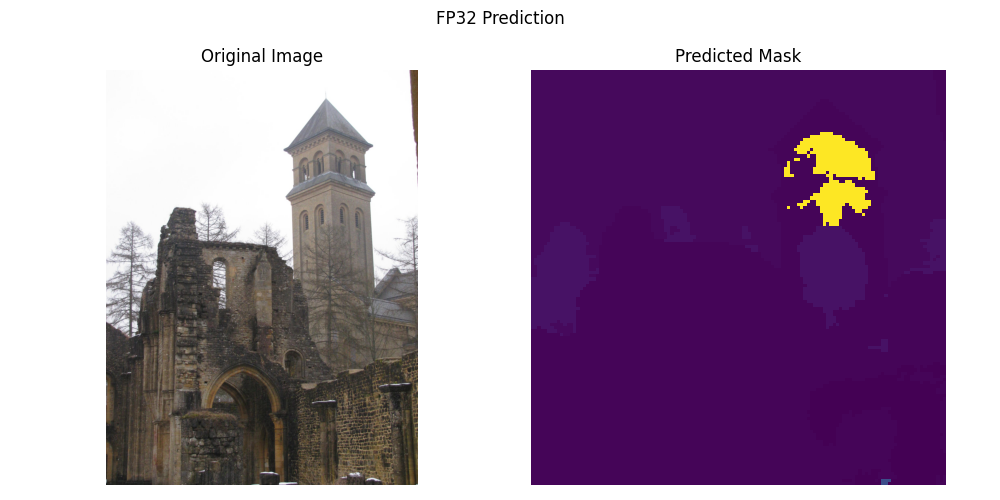

Displaying img1_FP64_compare.png


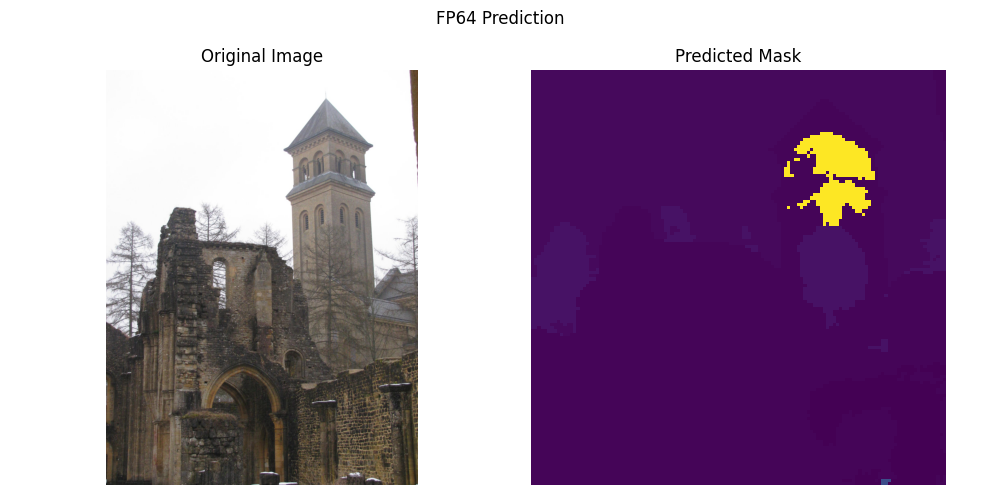

Displaying img1_P3109_compare.png


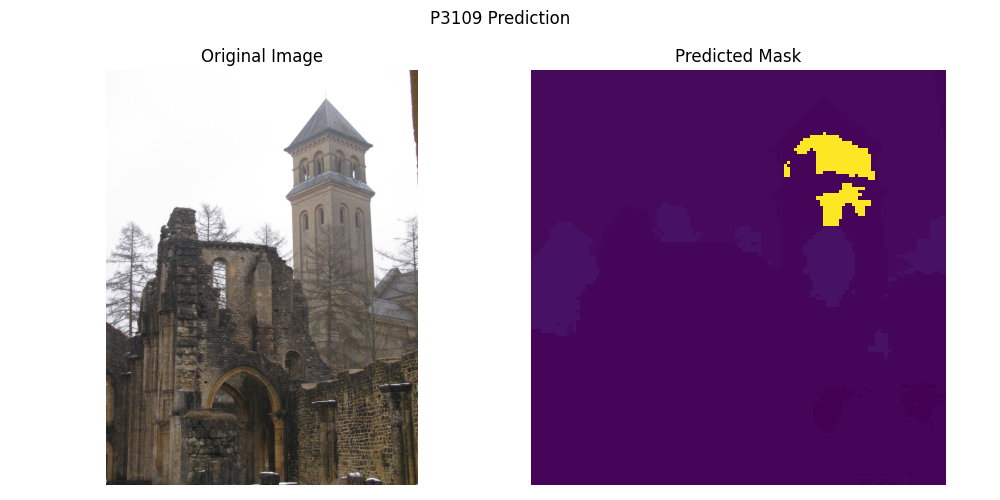

Displaying img1_TF32_compare.png


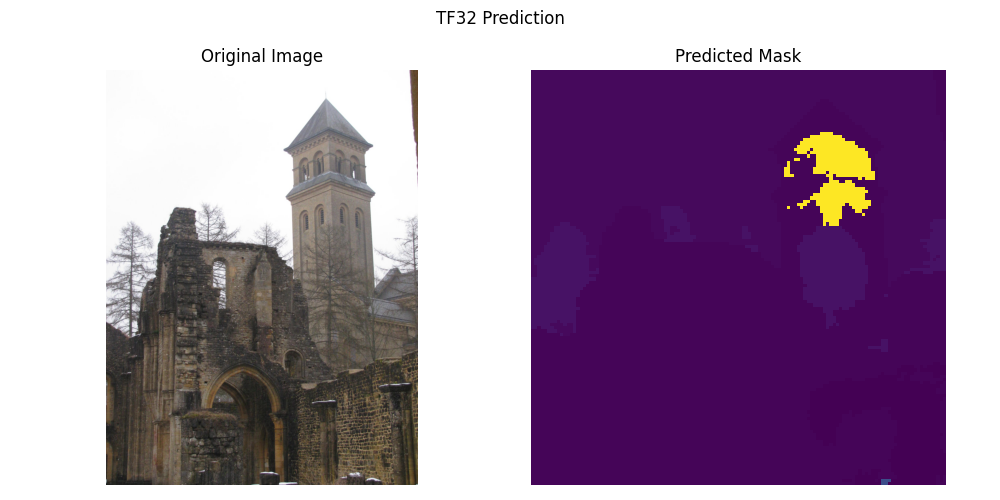

In [ ]:
import os
from IPython.display import display
from PIL import Image

vis_dir = "pred_visualizations"
all_files = sorted([f for f in os.listdir(vis_dir) if f.endswith(".png")])

for f in all_files:
    img_path = os.path.join(vis_dir, f)
    print(f"Displaying {f}")
    img = Image.open(img_path)
    display(img)


In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc
# !jupyter nbconvert --log-level INFO --to pdf /path/to/notebook_file.ipynb # make sure the ipynb name is correct
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MSCS/260
%pwd
# !ls
!jupyter nbconvert --to pdf "AllIn1_4.ipynb"


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://cli.github.com/packages stable InRelease [3,917 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,202 kB]
Get:13 https://cli.github.com/packages stable/main amd64 Packag